# General

In this Jupyter notebook, I will replicate the paper **"An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale" by Dosovitskiy et al.** with Pytorch. The paper proposes a new approach to image recognition using transformers, a type of neural network commonly used in natural language processing.

**ViT** - Stands for Vision Transformer. Short hand for the original machine learning research paper that introduced the ViT architecture, [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929), anytime ViT paper is mentioned, you can be assured it is referencing this paper.

## What's ViT made of?

1. **Figure 1** - This gives an overview of the model in a graphical sense, you could *almost* recreate the architecture with this figure alone.
2. **Four equations in section 3.1** - These equations give a little bit more of a mathematical grounding to the coloured blocks in Figure 1.
3. **Table 1** - This table shows the various hyperparameter settings (such as number of layers and number of hidden units) for different ViT model variants. We'll be focused on the smallest version, ViT-Base.

### Exploring Figure 1

1. **Layers** - takes an **input**, performs an operation or function on the input, produces an **output**.
2. **Blocks** - a collection of layers, which in turn also takes an **input** and produces an **output**.
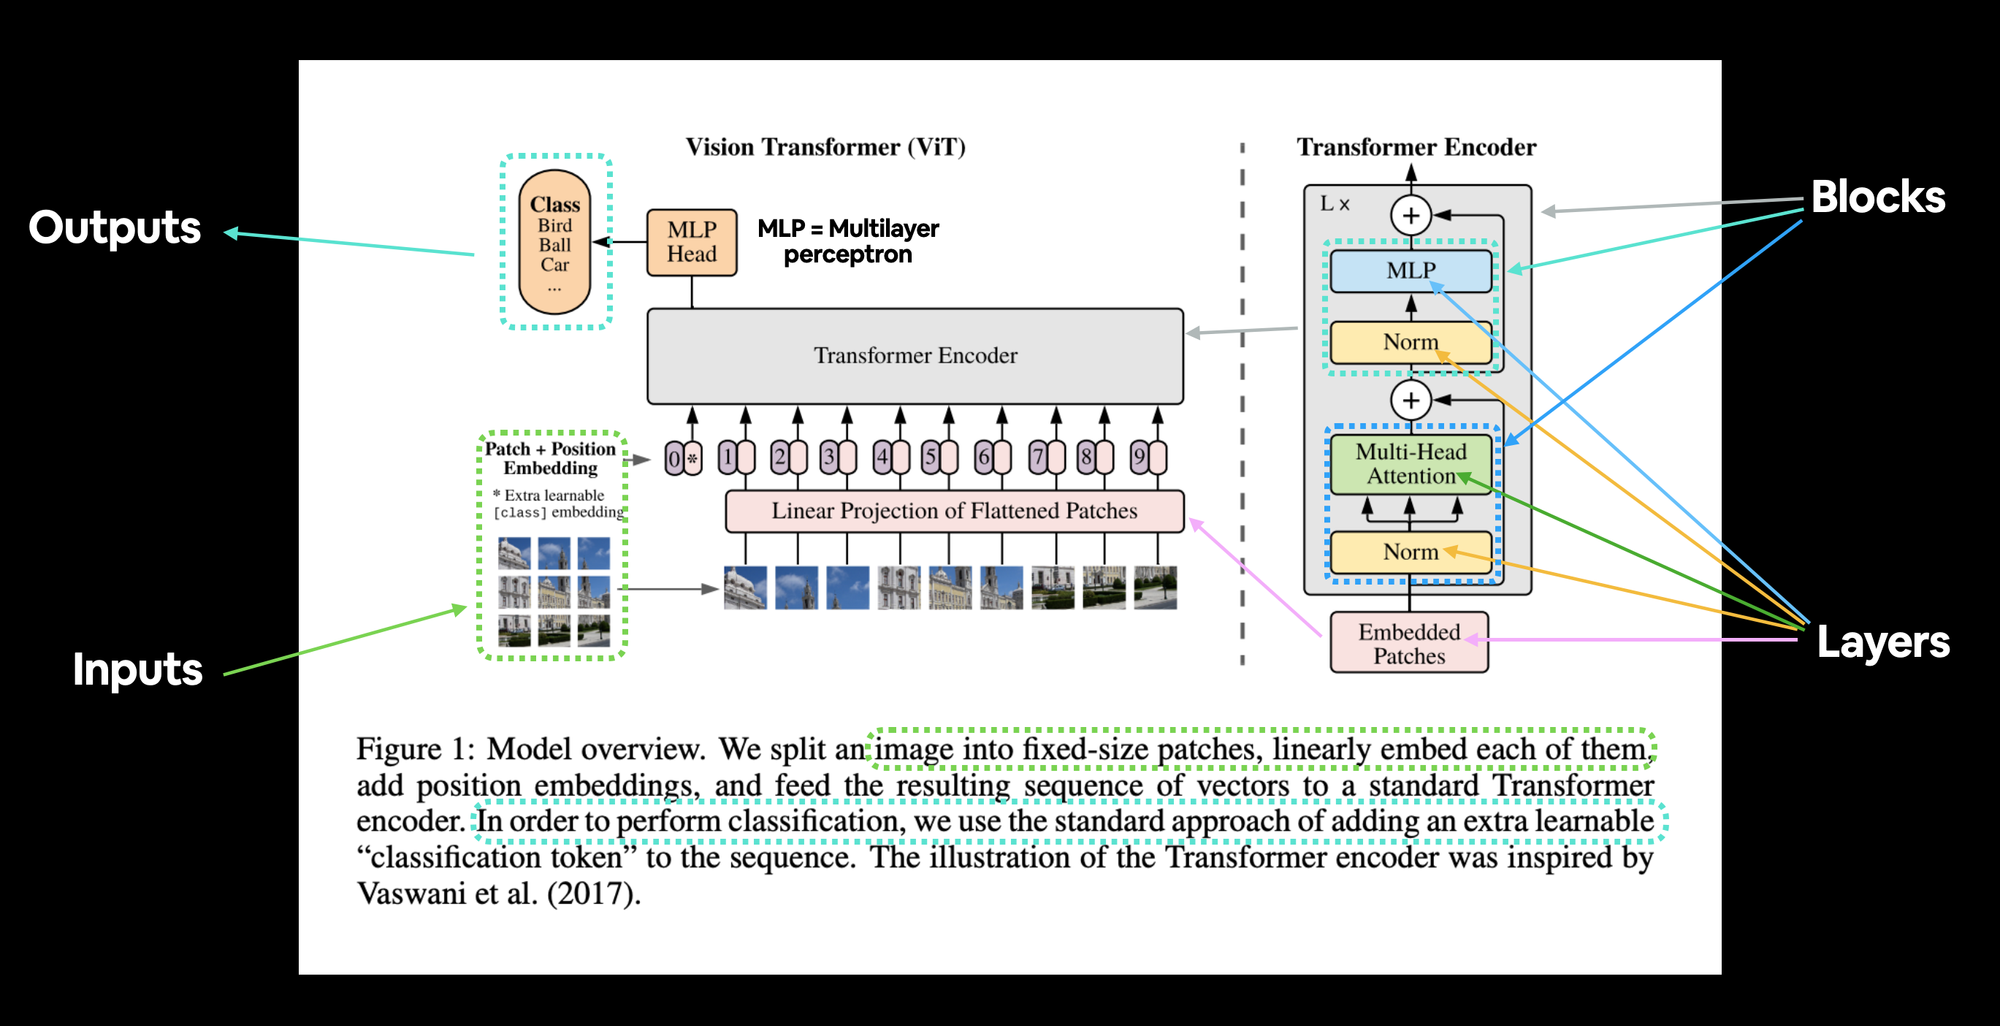

**The ViT architecture is comprised of several stages:**

- **Patch + Position Embedding (inputs)** - Turns the input image into a sequence of image patches and add a position number what order the patch comes in.
- **Linear projection of flattened patches (Embedded Patches)** - The image patches get turned into an **embedding**, the benefit of using an embedding rather than just the image values is that an embedding is a *learnable* representation (typically in the form of a vector) of the image that can improve with training.
- **Norm** - This is short for "[Layer Normalization](https://paperswithcode.com/method/layer-normalization)" or "LayerNorm", a technique for regularizing (reducing overfitting) a neural network, you can use LayerNorm via the PyTorch layer [torch.nn.LayerNorm()](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html).
- **Multi-Head Attention** - This is a [Multi-Headed Self-Attention layer](https://paperswithcode.com/method/multi-head-attention) or "MSA" for short. You can create an MSA layer via the PyTorch layer [torch.nn.MultiheadAttention()](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html).
- **MLP (or [Multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron))** - A MLP can often refer to any collection of feedforward layers (or in PyTorch's case, a collection of layers with a `forward()` method). In the ViT Paper, the authors refer to the MLP as "MLP block" and it contains two [torch.nn.Linear()](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layers with a [torch.nn.GELU()](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html) non-linearity activation in between them (section 3.1) and a [torch.nn.Dropout()](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) layer after each (Appendex B.1).
- **Transformer Encoder** - The Transformer Encoder, is a collection of the layers listed above. There are two skip connections inside the Transformer encoder (the "+" symbols) meaning the layer's inputs are fed directly to immediate layers as well as subsequent layers. The overall ViT architecture is comprised of a number of Transformer encoders stacked on top of eachother.
- **MLP Head** - This is the output layer of the architecture, it converts the learned features of an input to a class output. Since we're working on image classification, you could also call this the "classifier head". The structure of the MLP Head is similar to the MLP block.

### Exploring the Four Equations
**Equtions:**
$$\begin{aligned}
\mathbf{z}_0 & =\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_p^1 \mathbf{E} ; \mathbf{x}_p^2 \mathbf{E} ; \cdots ; \mathbf{x}_p^N \mathbf{E}\right]+\mathbf{E}_{p o s}, & & \mathbf{E} \in \mathbb{R}^{\left(P^2 \cdot C\right) \times D}, \mathbf{E}_{p o s} \in \mathbb{R}^{(N+1) \times D}  \qquad \space \space (1) \\
\mathbf{z}_{\ell}^{\prime} & =\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L \qquad \qquad \qquad \qquad \qquad \space (2) \\
\mathbf{z}_{\ell} & =\operatorname{MLP}\left(\mathrm{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \qquad \qquad \qquad \qquad \qquad \space (3) \\
\mathbf{y} & =\operatorname{LN}\left(\mathbf{z}_L^0\right) \quad (4) & &
\end{aligned}$$

**Pseudocode:**
1) ```x_input = [class_token, image_patch_1, image_patch_2, image_patch_3...] + [class_token_position, image_patch_1_position, image_patch_2_position, image_patch_3_position...]```
2) ```x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input```
3) ```x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block```
4) ```y = Linear_layer(LN_layer(x_output_MLP_block[0]))```

| Equation number | Description from ViT paper section 3.1 |
| --- | --- |
| 1 | The Transformer uses constant latent vector size D through all of its layers, so we flatten the patches and map to D dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings... Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings. | 
| 2 | The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski & Auli, 2019). |
| 3 | Same as equation 2. |
| 4 | Similar to BERT's [ class ] token, we prepend a learnable embedding to the sequence of embedded patches (z0 = xclass), whose state at the output of the Transformer encoder z0L serves as the image representation y (Eq. 4). |

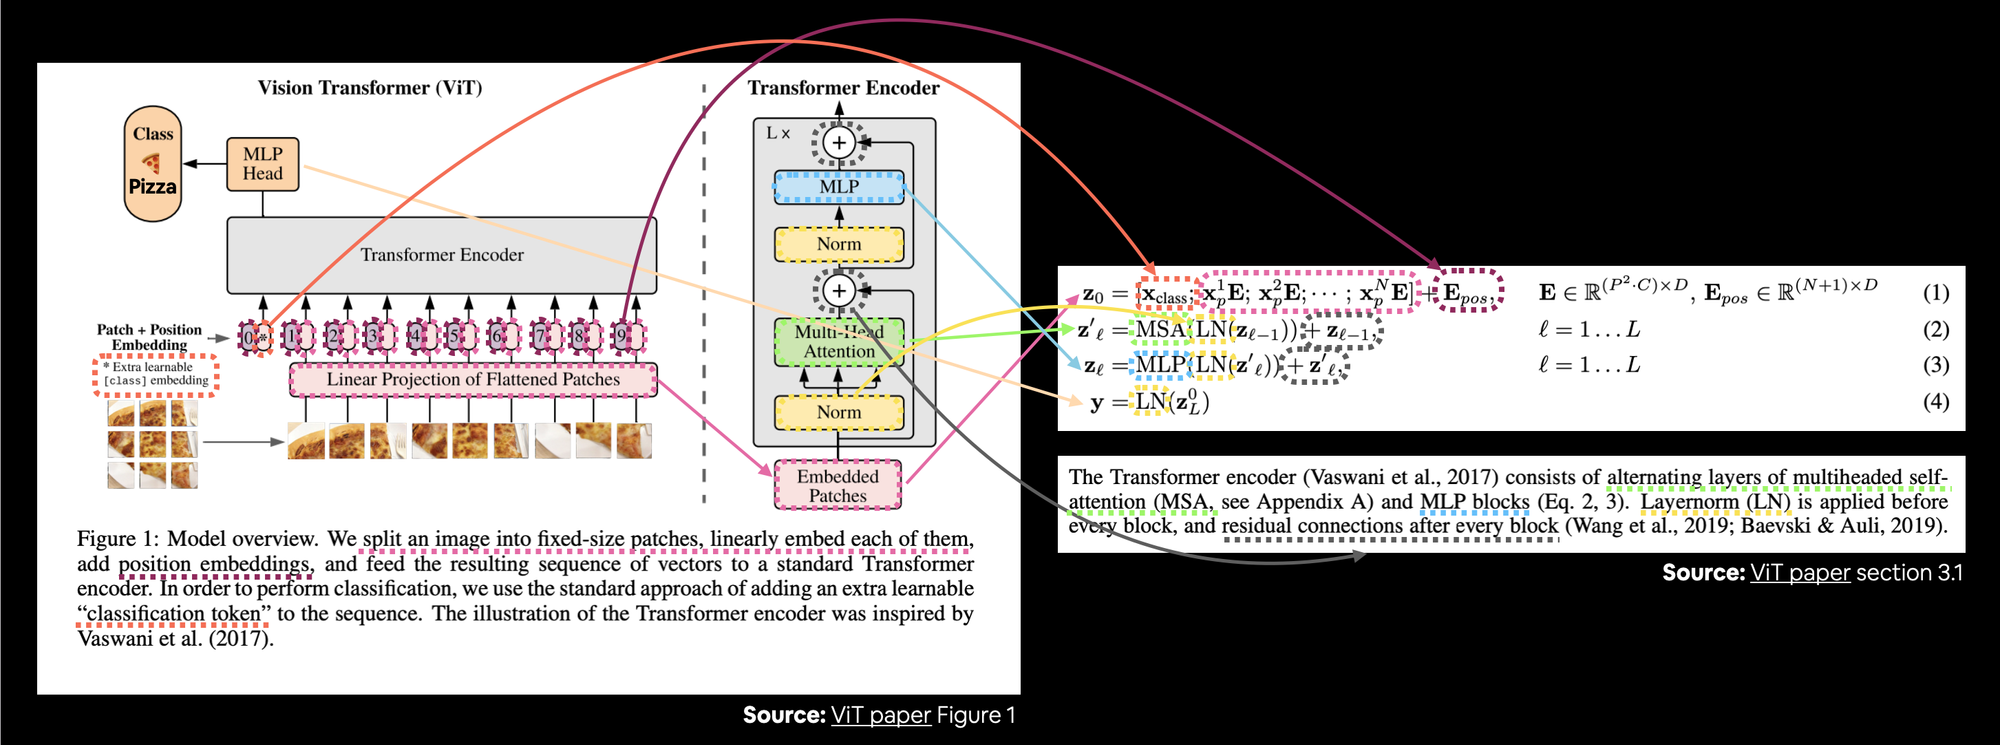

To handle $2 \mathrm{D}$  images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches , where $(H, W)$ is the **resolution** of the original image, $C$ is the **number of channels**,   $(P, P)$ is the **resolution** of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. 

The Transformer uses **constant latent vector** size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

**Position embeddings** are added to the patch embeddings to retain positional information. We use standard learnable $1 \mathrm{D}$  position embeddings, since we have not observed significant performance
gains from using more advanced $2 \mathrm{D}$-aware position embeddings. The resulting sequence of embedding vectors serves as **input** to the encoder.

### Exploring Table 1 (various hyperparameters of each of the ViT architectures)

| Model | Layers | Hidden size D | MLP size | Heads | Params |
| --- | --- | --- | --- | --- | --- |
ViT-Base|12|768|3072|12|86M
ViT-Large|24|1024|4096|16|307M
ViT-Huge|32|1280|5120|16|632M

**Breaking the hyperparameters down:**
- **Layers** - How many Transformer Encoder blocks are there? (each of these will contain a MSA block and MLP block)
- **Hidden size D** - This is the embedding dimension throughout the architecture, this will be the size of the vector that our image gets turned into when it gets patched and embedded. Generally, the larger the embedding dimension, the more information can be captured, the better results. However, a larger embedding comes at the cost of more compute.
- **MLP size** - What are the number of hidden units in the MLP layers?
- **Heads** - How many heads are there in the Multi-Head Attention layers?
- **Params** - What are the total number of parameters of the model? Generally, more parameters leads to better performance but at the cost of more compute. You'll notice even ViT-Base has far more parameters than any other model we've used so far.

# Preparation

This chapter will contain code for creating modular Python files for next tasks:
- **Data downloading** - ```data_downloader.py```
- **Helper functions** for training, visualizations etc. - ```utils.py```

## Script for data downloading
For this task i decided to use open dataset from Kaggle called [Animals-10](https://www.kaggle.com/datasets/alessiocorrado99/animals10?resource=download), contains images with ten different animals.

In [1]:
%%writefile data_download.py

import os
import pathlib
import zipfile
import shutil
from kaggle.api.kaggle_api_extended import KaggleApi

from tqdm import tqdm

def data_downloader(dataset_key='alessiocorrado99/animals10',
                    kaggle_username='seblful',
                    kaggle_api='6757c11d0dc1367e16a1a6b9fab157d1'):
    '''
    Downloads data from Kaggle, creates new directories,
    and deletes old files
    '''
    data_path = pathlib.Path('data')
    
    # Check if directory 'data' in repository
    if data_path.is_dir() == False: # change to false
        os.mkdir('data')
        print("There are no have directory 'data', creating new one")
        
        # Setting Kaggle environment
        os.environ['KAGGLE_USERNAME'] = kaggle_username
        os.environ['KAGGLE_KEY'] = kaggle_api

        api = KaggleApi()
        api.authenticate()
        
        with tqdm(total=100) as t:
            # Download data from Kaggle 
            print('Downloading data...')
            api.dataset_download_files(dataset_key, path=data_path)
            print('Data has downloaded')
        
        with tqdm(total=100) as t:
            # Getting name of archive
            zip_path = list(data_path.glob('*.zip'))[0]
            # Extracting files from archive
            print('Extracting files from archive...')
            with zipfile.ZipFile(zip_path, 'r') as zip_file:
                zip_file.extractall(data_path)
            print('Files has extracted')

            # Deleting zipfile
            try:
                os.remove(zip_path)
            except PermissionError as ex:
                print(f"Couldn't delete zip file for {ex}")

        # Check if data_path doesn't contain additional directories inside and deleting if does
        list_of_dirs_in_data = [file for file in data_path.iterdir() if file.is_dir()]
        print(list_of_dirs_in_data)
        if len(list_of_dirs_in_data) == 1:
            added_dir_path = list_of_dirs_in_data[0]
            
            list_of_dirs_in_added_dir = os.listdir(added_dir_path)
            
            # Looping through each folder in added dir and moving to data_path
            for image_class in list_of_dirs_in_added_dir:
                original_path = added_dir_path / image_class
                print('Orig', original_path)
                
                new_path = data_path / image_class
                print('new_path', new_path)
                # Moving files
                shutil.move(original_path, new_path)
            print('Folders has removed')
            
            # Deleting emptyExceptionded folder
            try:
                os.remove(added_dir_path)
            except PermissionError as ex:
                print(f"Couldn't delete added dir path for {ex}")
        
        # Checking presence of translate file to rename folders and renaming them
        translate_file_path = data_path / 'translate.py'
        if translate_file_path.is_file():
            # Importing dict with translation
            from data.translate import translate
            # Adding missing key
            translate['ragno'] = 'spider'
            translate['raw-img'] = 'raw-img'
            translate['__pycache__'] = '__pycache__'
            
            # Creating list with folders
            list_of_dirs_in_data = [file for file in data_path.iterdir() if file.is_dir()]
            # Looping through folders in data_path and rename folders
            for folder in list_of_dirs_in_data:
                folder.rename(data_path / translate[folder.name])
                print('Name of folders has renamed')
                
            try:
                os.remove(data_path/'translate.py')
            except PermissionError as ex:
                print(f"Couldn't delete translate.py for {ex}")

    else:
        print("The repository has directory 'data'")

data_downloader()

Overwriting data_download.py


## Utils script

This script contains several functions for creating dataloaders, training, visualisations

In [52]:
%%writefile utils.py

import os
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms


import matplotlib.pyplot as plt
import torch
import random

def make_dataloaders(data_path, 
                     train_size=0.85,
                     test_size=0.15,
                     batch_size=32):
    '''
    Creates train and test dataloaders
    '''
    # Defining num workers
    num_workers = os.cpu_count()
    
    # Creating transformer to transform data
    transformer = transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor()
        ])
    
    # Creating train and test dataset
    full_dataset = datasets.ImageFolder(root=data_path,
                                        transform=transformer)
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])
    

    # Creating train and test dataloader
    train_dataloader = DataLoader(dataset=train_dataset,
                                 batch_size=batch_size,
                                 shuffle=True,
                                 num_workers=num_workers,
                                 pin_memory=True)
    
    test_dataloader = DataLoader(dataset=test_dataset,
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=num_workers,
                                pin_memory=True)
    
    return train_dataloader, test_dataloader, full_dataset.classes, full_dataset.class_to_idx


def visualize_dataloader_images(dataloader,
                                classes=None,
                                nrows=4,
                                ncols=4):
    '''
    Visualizes random images from DataLoader
    '''
    # Taking one batch and one label
    batch, label = next(iter(dataloader))
    
    # Create a nrows*ncols grid of subplots
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols)
    
    # Subplotting
    for i in range(nrows):
        for j in range(ncols):
            random_index = torch.randint(32, size=(1,))[0]
            image = batch[random_index]
            axs[i, j].imshow(image.permute(1, 2, 0))
            axs[i, j].axis('off')
            
            if classes is not None:
                axs[i, j].set_title(classes[label[random_index]])
                
    plt.tight_layout()
    plt.show()
    

def plot_patchified_image(image, patch_size):
    '''
    Plots patched image
    '''
    # Permuting image
    image_permuted = image.permute(1, 2, 0)
    
    # Setting image size (image always square) and num_patches
    image_size = image_permuted.shape[0]
    num_patches = int(image_size / patch_size)
    
    # Check if image size is divided without remainder
    assert image_size % patch_size == 0
    
    figs, axs = plt.subplots(nrows=int(image_size / patch_size),
                            ncols=int(image_size / patch_size),
                            figsize=(num_patches, num_patches),
                            sharex=True,
                            sharey=True)
    
    for i, patch_height in enumerate(range(0, image_size, patch_size)):
        for j, patch_width in enumerate(range(0, image_size, patch_size)):
            # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
            axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size,
                             patch_width:patch_width+patch_size, :])
            
            # Set up label information, remove the ticks for clarity and set labels to outside
            axs[i, j].set_ylabel(i+1, 
                                 rotation="horizontal", 
                                 horizontalalignment="right", 
                                 verticalalignment="center") 
            axs[i, j].set_xlabel(j+1) 
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
            axs[i, j].label_outer()
    
    # Set a super title
    figs.suptitle("Patchified image", fontsize=16)
    plt.show()
    

def plot_image_out_of_conv(image, k=5):
    '''
    Plots patchified image by a convolutional layer
    '''
    # Instantiate k random indexes
    random_indexes = random.sample(range(0, 758), k=k)
    
    figs, axs = plt.subplots(nrows=1, ncols=k)
    
    for i, idx in enumerate(random_indexes):
        # Taking random image and prepare it for plotting
        random_image = image[:, idx, :, :].squeeze().detach().numpy()
        # Plotting each subplot
        axs[i].imshow(random_image)
        # Deleting labels, ticks
        axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);
        
    
import matplotlib.pyplot as plt

def plot_image_out_of_flat(flattened_image):
    '''
    Plots flattened feauture map
    '''
    # Permute, taking single map and detach image
    single_flatten_map = flattened_image.permute(0, 2, 1)[:, :, 0].detach().numpy()
    
    # Change figsize
    plt.figure(figsize=(20, 20))
    plt.imshow(single_flatten_map)
    plt.axis('off');

Overwriting utils.py


# Preparing for replicating paper

## Instantiation constant variables

In [3]:
import pathlib

DATA_PATH = pathlib.Path('data')
BATCH_SIZE=32
TRAIN_SIZE = 0.85
TEST_SIZE=0.15

In [4]:
import torch

device = 'cuda' if torch.cuda.is_available else 'cpu'
print(f"Using device is {device}.")

Using device is cuda.


## Create train and test dataloaders

In [5]:
from utils import make_dataloaders
train_dataloader, test_dataloader, classes, class_to_idx = make_dataloaders(data_path=DATA_PATH,
                                                                           train_size=TRAIN_SIZE,
                                                                           test_size=TEST_SIZE,
                                                                           batch_size=BATCH_SIZE)
print(f"Length of train_dataloader is {len(train_dataloader)}.\
        \nLength of test_dataloader is {len(test_dataloader)}.")

Length of train_dataloader is 696.        
Length of test_dataloader is 123.


### Taking batches for next replicating

In [6]:
image_batch, label_batch = next(iter(train_dataloader))
print(f"Shape of image_batch is {tuple(image_batch.shape)}\
        \nShape of label_batch is {tuple(label_batch.shape)}")

Shape of image_batch is (32, 3, 224, 224)        
Shape of label_batch is (32,)


### Taking one image and one label from batch for next replicating

In [7]:
image, label = image_batch[0], label_batch[0]
print(f"Shape of image is {tuple(image.shape)}\
        \nLabel is equal {label}")

Shape of image is (3, 224, 224)        
Label is equal 4


## Vizualize random images from DataLoader

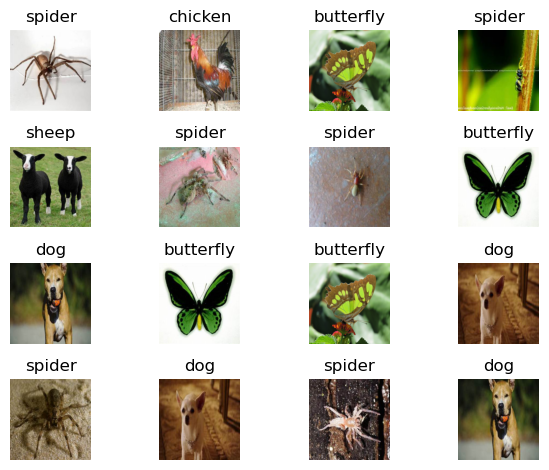

In [8]:
from utils import visualize_dataloader_images
visualize_dataloader_images(train_dataloader, classes=classes)

## Replicating ViT

**Let's break down the text above.**

- $\mathrm{D}$ is the size of the **patch embeddings**
- The image starts as $2 \mathrm{D}$ with size  $H×W×C$.
    - $H, W$ is the resolution of the original image **(height, width).**
    - $C$ is the number of channels.
- The image gets converted to a sequence of flattened $2 \mathrm{D}$ patches with size $N×(P^2⋅C)$.
    - $(P,P)$ is the resolution of each image patch (**patch size**).
    - $N=HW/P^2$  is the resulting number of patches, which also serves as the input sequence length for the Transformer.

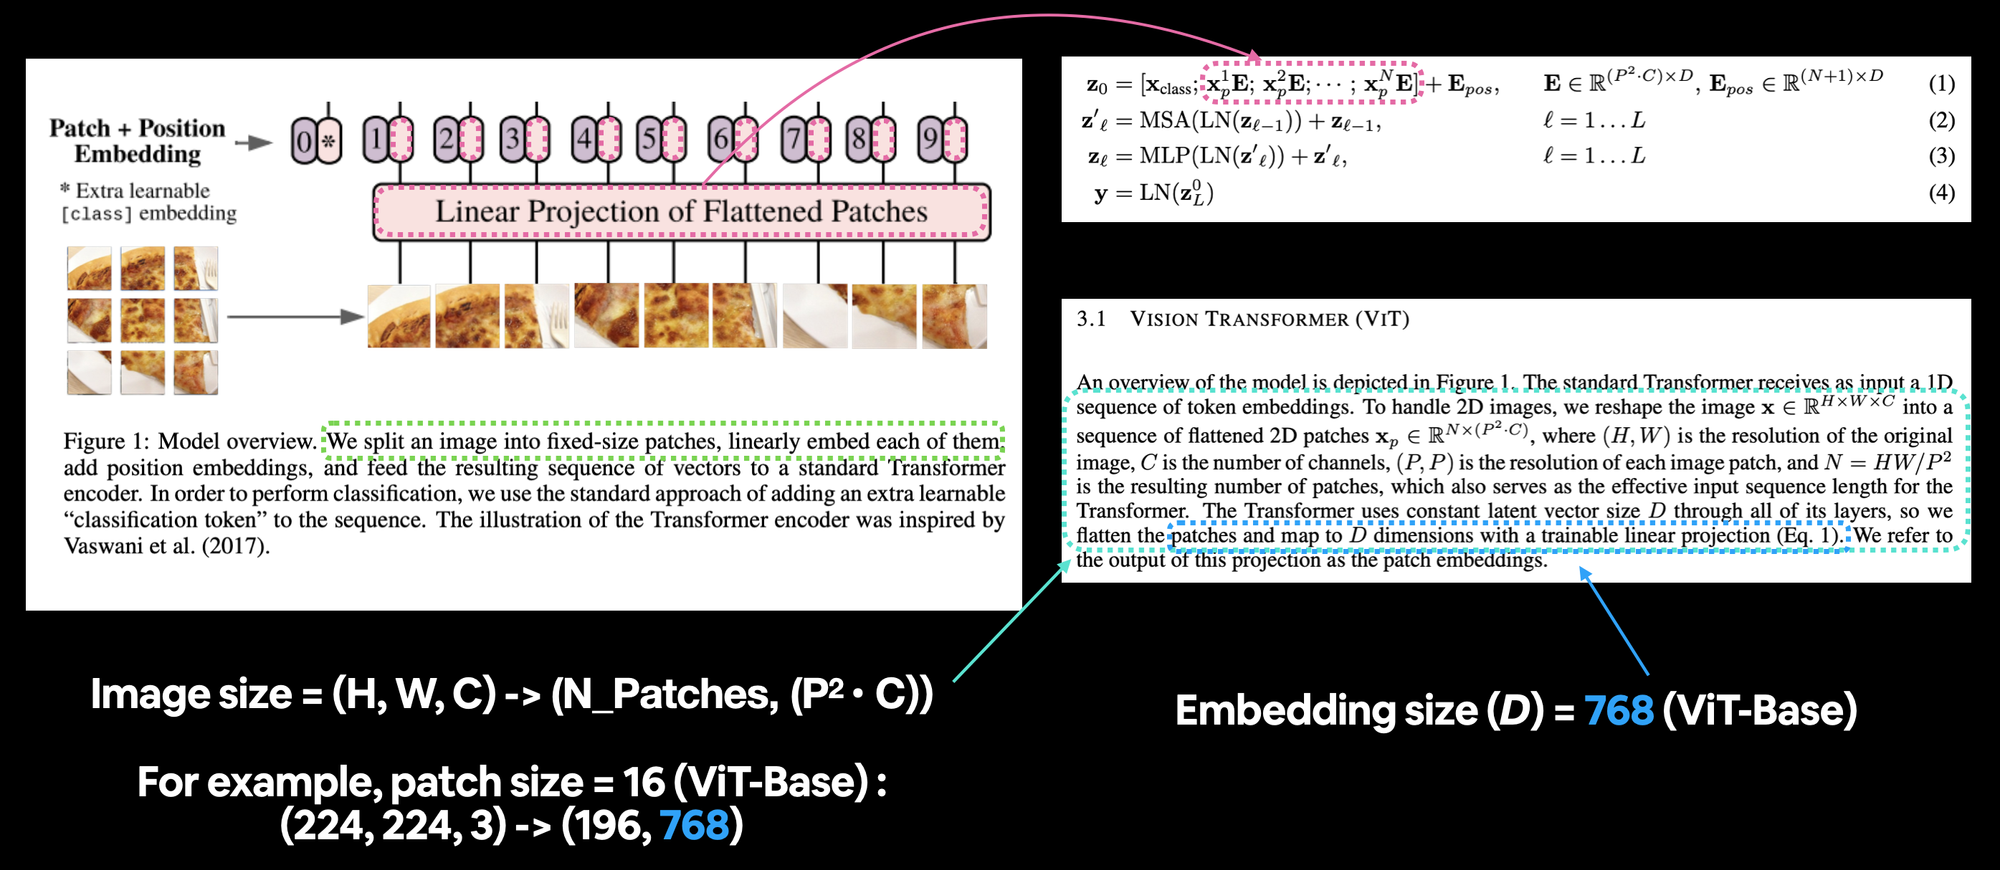

### Instantiate variables

In [9]:
color_channels, height, width = image.shape

patch_size = 16
number_of_patches = int(height*width / patch_size**2)

print(f"Number of patches with image with shape {color_channels, height, width} and patch size {patch_size} is {number_of_patches}")

Number of patches with image with shape (3, 224, 224) and patch size 16 is 196


In [10]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


### Turning image into patches, split data into patches and creating the class, position and patch embedding

#### Visualise image patches

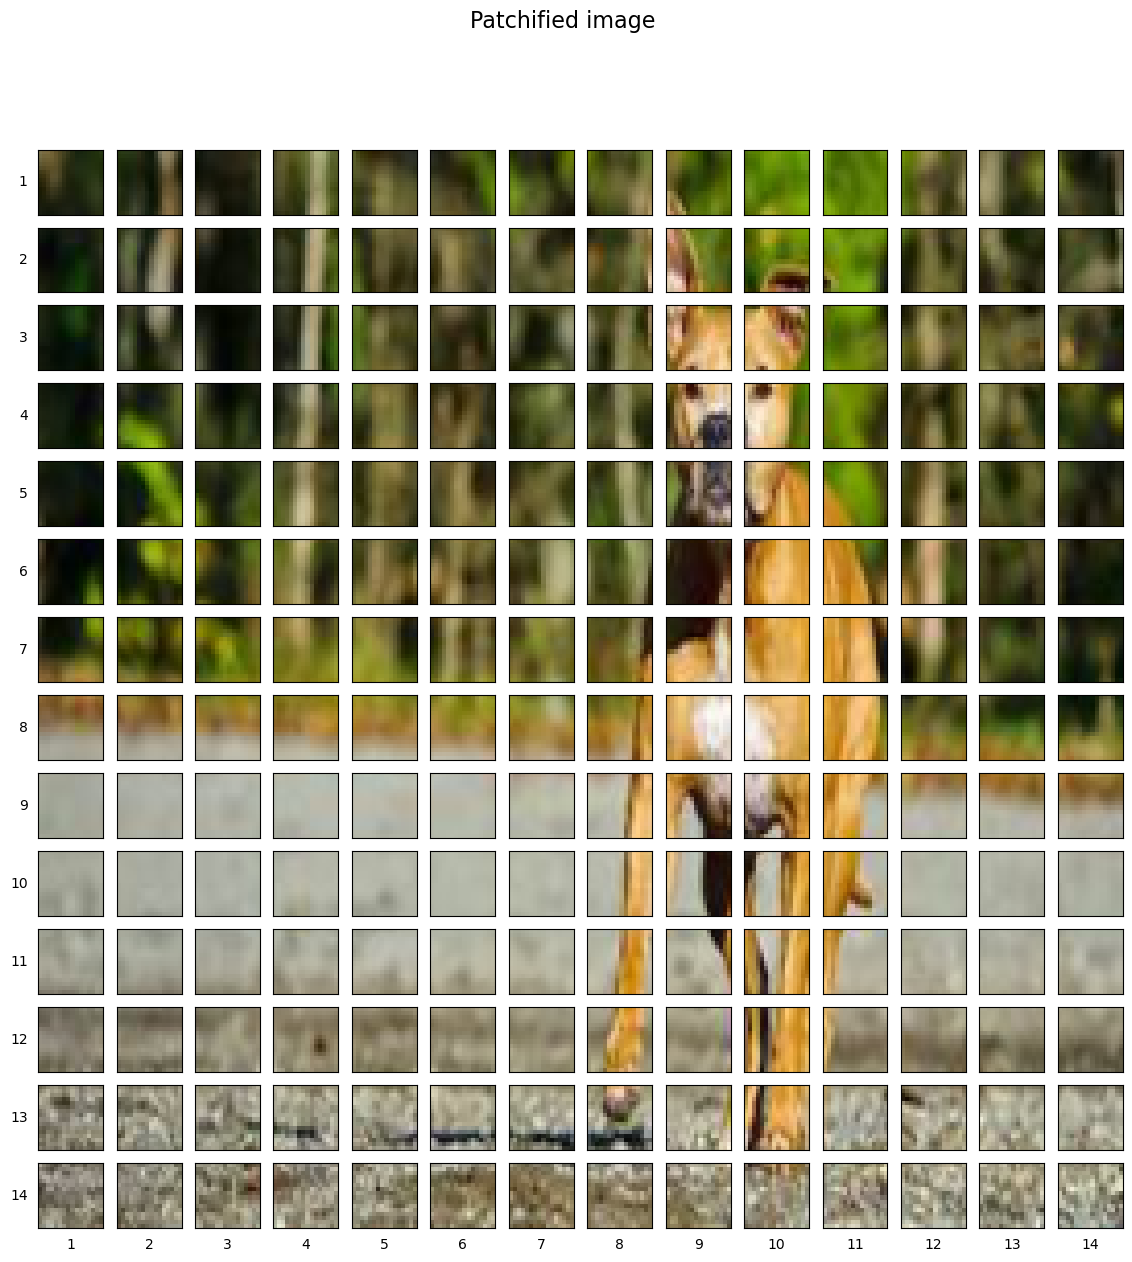

In [11]:
from utils import plot_patchified_image
plot_patchified_image(image, patch_size)

#### Creating image patches with torch.nn.Conv2d()

In [12]:
from torch import nn

# Set the patch size
patch_size=16

# Create the Conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # number of color channels
                   out_channels=768, # from Table 1: Hidden size D, this is the embedding size
                   kernel_size=patch_size, # could also use (patch_size, patch_size)
                   stride=patch_size,
                   padding=0)

**Pass the image through the convolutional layer**

In [13]:
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


**Visualize image patches**

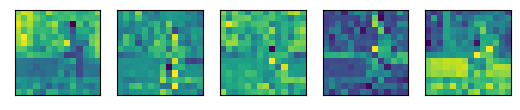

In [14]:
from utils import plot_image_out_of_conv
plot_image_out_of_conv(image_out_of_conv)

**Get a single feauture map**

In [15]:
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad # -> torch.Size([1, 196])

(tensor([[[-0.0080,  0.0520, -0.0058, -0.0866, -0.0701,  0.0077,  0.0137,
           -0.0570, -0.0115, -0.1479, -0.0629,  0.0158,  0.0521, -0.0569],
          [-0.0452,  0.0046, -0.0260, -0.1574,  0.0435, -0.0555,  0.0012,
           -0.1026,  0.0140, -0.0139, -0.0951, -0.0413, -0.0512, -0.1643],
          [-0.0189, -0.0140,  0.0149, -0.2374,  0.0354, -0.0640, -0.0039,
           -0.1680, -0.1571, -0.1206, -0.0854, -0.0042, -0.0255,  0.0011],
          [-0.0365, -0.0852,  0.0148, -0.0926, -0.0511, -0.1066, -0.0471,
           -0.0744, -0.1858,  0.0336, -0.0879, -0.0992, -0.0493,  0.0124],
          [-0.0082, -0.0737,  0.0104,  0.0159, -0.0713, -0.0813, -0.0804,
           -0.1288,  0.0396, -0.2122, -0.1357, -0.1494, -0.0060, -0.0010],
          [ 0.0028, -0.0179,  0.0085,  0.0704, -0.0317,  0.0038, -0.0453,
            0.0296,  0.0007, -0.2805, -0.1287, -0.0383,  0.0230,  0.0009],
          [-0.0718, -0.0094, -0.1608, -0.0690, -0.1118,  0.0492, -0.0490,
           -0.0464,  0.0005, -0.

The grad_fn output of the single_feature_mapand the requires_grad=Trueattribute means PyTorch is tracking the gradients of this feature map and it will be updated by gradient descent during training.

#### Flatten image for right shape

**Create flatten layer**

In [16]:
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

In [17]:
image_out_of_flatten = flatten(image_out_of_conv)
image_out_of_flatten.shape

torch.Size([1, 768, 196])

**Visualize flattened feauture map**

In [51]:
from utils import plot_image_out_of_flat
plot_image_out_of_flat(image_out_of_flatten)

### Putting all together

In [ ]:
# 1. View hsape of single image
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")